<a href="https://colab.research.google.com/github/sakasa/notebooks/blob/master/tokyo_covid19_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from pytz import timezone
import numpy as np
import seaborn as sns

%matplotlib inline

### Tokyo COVID19 Data
https://github.com/tokyo-metropolitan-gov/covid19

In [2]:
url = 'https://raw.githubusercontent.com/tokyo-metropolitan-gov/covid19/development/data/data.json'

In [3]:
response = requests.get(url)
print(response)
j_res = json.loads(response.text) # json文字列をdictへ
print(j_res.keys())
j_res['patients_summary']['data'][-15:]

<Response [200]>
dict_keys(['contacts', 'querents', 'patients_summary', 'inspections_summary', 'lastUpdate', 'main_summary'])


[{'小計': 16129, '日付': '2022-02-18T08:00:00.000Z'},
 {'小計': 13516, '日付': '2022-02-19T08:00:00.000Z'},
 {'小計': 12935, '日付': '2022-02-20T08:00:00.000Z'},
 {'小計': 8805, '日付': '2022-02-21T08:00:00.000Z'},
 {'小計': 11443, '日付': '2022-02-22T08:00:00.000Z'},
 {'小計': 14567, '日付': '2022-02-23T08:00:00.000Z'},
 {'小計': 10169, '日付': '2022-02-24T08:00:00.000Z'},
 {'小計': 11125, '日付': '2022-02-25T08:00:00.000Z'},
 {'小計': 11562, '日付': '2022-02-26T08:00:00.000Z'},
 {'小計': 10321, '日付': '2022-02-27T08:00:00.000Z'},
 {'小計': 9632, '日付': '2022-02-28T08:00:00.000Z'},
 {'小計': 11813, '日付': '2022-03-01T08:00:00.000Z'},
 {'小計': 12693, '日付': '2022-03-02T08:00:00.000Z'},
 {'小計': 12251, '日付': '2022-03-03T08:00:00.000Z'},
 {'小計': 10517, '日付': '2022-03-04T08:00:00.000Z'}]

In [4]:
def utc_datestr_to_jst_date(datestr):
  #return datetime.datetime.fromisoformat(datestr.replace('Z', '+00:00')).astimezone(timezone('Asia/Tokyo'))
  # for ~Python3.6
  return datetime.datetime.strptime(datestr.split('.')[0].replace('-', '').replace(':', ''), '%Y%m%dT%H%M%S').astimezone(timezone('Asia/Tokyo'))

In [5]:
keys = ['contacts', 'querents', 'patients_summary']

In [6]:
d = j_res
df = pd.DataFrame()
for key in keys:
  k = f'{key.split("_")[0]}_count'
  for v in d[key].values():
    if type(v) is list:
      index = [_v['日付'] for _v in v]
      tmp_df = pd.DataFrame(_v for _v in v)
      tmp_df.index = [utc_datestr_to_jst_date(dt) for dt in tmp_df['日付']]
      tmp_df[k] = tmp_df['小計']
  df = pd.concat([df, tmp_df[k]], axis=1)
df = df.fillna(0).astype('int64')
df.index = [i for i in df.index]
df['datetime'] = df.index
df

,contacts_count,querents_count,patients_count,datetime
2020-01-24 17:00:00+09:00,0,0,1,2020-01-24 17:00:00+09:00
2020-01-25 17:00:00+09:00,0,0,1,2020-01-25 17:00:00+09:00
2020-01-26 17:00:00+09:00,0,0,0,2020-01-26 17:00:00+09:00
2020-01-27 17:00:00+09:00,0,0,0,2020-01-27 17:00:00+09:00
2020-01-28 17:00:00+09:00,0,0,0,2020-01-28 17:00:00+09:00
...,...,...,...,...
2022-02-28 17:00:00+09:00,1013,0,9632,2022-02-28 17:00:00+09:00
2022-03-01 17:00:00+09:00,899,0,11813,2022-03-01 17:00:00+09:00
2022-03-02 17:00:00+09:00,834,0,12693,2022-03-02 17:00:00+09:00
2022-03-03 17:00:00+09:00,766,0,12251,2022-03-03 17:00:00+09:00


In [7]:
# 7日移動平均
df1 = df
for key in keys:
  k = key.split('_')[0]
  df1[f'{k}_7d_mov_ave'] = df[f'{k}_count'].rolling('7D').mean()
  # df1[f'{k}_7d_mov_center_ave'] = df[f'{k}_count'].rolling(7, center=True).mean()
  df1[f'{k}_7d_mov_sum'] = df[f'{k}_count'].rolling('7D').sum()
df1.tail()

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum
2022-02-28 17:00:00+09:00,1013,0,9632,2022-02-28 17:00:00+09:00,1022.428571,7157.0,0.0,0.0,11259.857143,78819.0
2022-03-01 17:00:00+09:00,899,0,11813,2022-03-01 17:00:00+09:00,1000.000000,7000.0,0.0,0.0,11312.714286,79189.0
2022-03-02 17:00:00+09:00,834,0,12693,2022-03-02 17:00:00+09:00,960.714286,6725.0,0.0,0.0,11045.000000,77315.0
2022-03-03 17:00:00+09:00,766,0,12251,2022-03-03 17:00:00+09:00,923.857143,6467.0,0.0,0.0,11342.428571,79397.0
2022-03-04 17:00:00+09:00,0,0,10517,2022-03-04 17:00:00+09:00,788.714286,5521.0,0.0,0.0,11255.571429,78789.0


In [8]:
df2 = df1
# 日付が年の何週目かを列にセット `'{yy}w{week nnum}`
df2['week_num'] = [f'\'{d.strftime("%y")}w{d.strftime("%V")}' for d in df1.index]
# 曜日の列をセット
df2['week_day'] = [d.strftime('%a') for d in df1.index]
df2.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day
2022-02-18 17:00:00+09:00,1129,0,16129,2022-02-18 17:00:00+09:00,1417.285714,9921.0,0.0,0.0,14574.571429,102022.0,'22w07,Fri
2022-02-19 17:00:00+09:00,1293,0,13516,2022-02-19 17:00:00+09:00,1347.000000,9429.0,0.0,0.0,14824.714286,103773.0,'22w07,Sat
2022-02-20 17:00:00+09:00,1061,0,12935,2022-02-20 17:00:00+09:00,1300.714286,9105.0,0.0,0.0,14804.857143,103634.0,'22w07,Sun
2022-02-21 17:00:00+09:00,1321,0,8805,2022-02-21 17:00:00+09:00,1238.000000,8666.0,0.0,0.0,14586.428571,102105.0,'22w08,Mon
2022-02-22 17:00:00+09:00,1056,0,11443,2022-02-22 17:00:00+09:00,1195.142857,8366.0,0.0,0.0,14003.285714,98023.0,'22w08,Tue
2022-02-23 17:00:00+09:00,1109,0,14567,2022-02-23 17:00:00+09:00,1167.857143,8175.0,0.0,0.0,13608.428571,95259.0,'22w08,Wed
2022-02-24 17:00:00+09:00,1024,0,10169,2022-02-24 17:00:00+09:00,1141.857143,7993.0,0.0,0.0,12509.142857,87564.0,'22w08,Thu
2022-02-25 17:00:00+09:00,946,0,11125,2022-02-25 17:00:00+09:00,1115.714286,7810.0,0.0,0.0,11794.285714,82560.0,'22w08,Fri
2022-02-26 17:00:00+09:00,1070,0,11562,2022-02-26 17:00:00+09:00,1083.857143,7587.0,0.0,0.0,11515.142857,80606.0,'22w08,Sat
2022-02-27 17:00:00+09:00,939,0,10321,2022-02-27 17:00:00+09:00,1066.428571,7465.0,0.0,0.0,11141.714286,77992.0,'22w08,Sun


In [9]:
# 週毎に集計
groupby_week_num = df2.groupby('week_num', as_index=True)

In [10]:
# 集計結果から平均と合計を取得しデータフレームにセット
patients_week_num_df = pd.DataFrame({
    # 'patients_week_num': df2['week_num'].unique(),
    'patients_week_mean': [m for m in groupby_week_num.agg({'patients_count': 'mean'})['patients_count']], 
    'patients_week_sum': [s for s in groupby_week_num.agg({'patients_count': 'sum'})['patients_count']]
  }, index=[d for d in groupby_week_num.agg({'datetime': 'max'})['datetime']])
patients_week_num_df.tail()

,patients_week_mean,patients_week_sum
2022-02-13 17:00:00+09:00,15714.428571,110001
2022-02-20 17:00:00+09:00,14804.857143,103634
2022-02-27 17:00:00+09:00,11141.714286,77992
2022-03-04 17:00:00+09:00,11381.200000,56906
2022-01-02 17:00:00+09:00,80.000000,160


In [11]:
df3 = pd.concat([
                df2,
                patients_week_num_df.loc[:, ['patients_week_mean', 'patients_week_sum']]
                ], axis=1)
df3.tail(15)

,contacts_count,querents_count,patients_count,datetime,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_7d_mov_ave,querents_7d_mov_sum,patients_7d_mov_ave,patients_7d_mov_sum,week_num,week_day,patients_week_mean,patients_week_sum
2022-02-18 17:00:00+09:00,1129,0,16129,2022-02-18 17:00:00+09:00,1417.285714,9921.0,0.0,0.0,14574.571429,102022.0,'22w07,Fri,NaN,NaN
2022-02-19 17:00:00+09:00,1293,0,13516,2022-02-19 17:00:00+09:00,1347.000000,9429.0,0.0,0.0,14824.714286,103773.0,'22w07,Sat,NaN,NaN
2022-02-20 17:00:00+09:00,1061,0,12935,2022-02-20 17:00:00+09:00,1300.714286,9105.0,0.0,0.0,14804.857143,103634.0,'22w07,Sun,14804.857143,103634.0
2022-02-21 17:00:00+09:00,1321,0,8805,2022-02-21 17:00:00+09:00,1238.000000,8666.0,0.0,0.0,14586.428571,102105.0,'22w08,Mon,NaN,NaN
2022-02-22 17:00:00+09:00,1056,0,11443,2022-02-22 17:00:00+09:00,1195.142857,8366.0,0.0,0.0,14003.285714,98023.0,'22w08,Tue,NaN,NaN
2022-02-23 17:00:00+09:00,1109,0,14567,2022-02-23 17:00:00+09:00,1167.857143,8175.0,0.0,0.0,13608.428571,95259.0,'22w08,Wed,NaN,NaN
2022-02-24 17:00:00+09:00,1024,0,10169,2022-02-24 17:00:00+09:00,1141.857143,7993.0,0.0,0.0,12509.142857,87564.0,'22w08,Thu,NaN,NaN
2022-02-25 17:00:00+09:00,946,0,11125,2022-02-25 17:00:00+09:00,1115.714286,7810.0,0.0,0.0,11794.285714,82560.0,'22w08,Fri,NaN,NaN
2022-02-26 17:00:00+09:00,1070,0,11562,2022-02-26 17:00:00+09:00,1083.857143,7587.0,0.0,0.0,11515.142857,80606.0,'22w08,Sat,NaN,NaN
2022-02-27 17:00:00+09:00,939,0,10321,2022-02-27 17:00:00+09:00,1066.428571,7465.0,0.0,0.0,11141.714286,77992.0,'22w08,Sun,11141.714286,77992.0


### グラフ出力

In [12]:
sns.set()
sns.set_style('whitegrid')

In [13]:
### 日毎の数
x = df3.index
y1_1 = df3['patients_count']
y1_2 = df3['patients_7d_mov_ave']
#y1_3 = df3['patients_7d_mov_center_ave']
# y1_4 = df3['patients_week_mean']

In [14]:
### 週毎の数
# y2_1 = df3['patients_7d_mov_sum']
# y2_2 = df3['patients_week_sum']

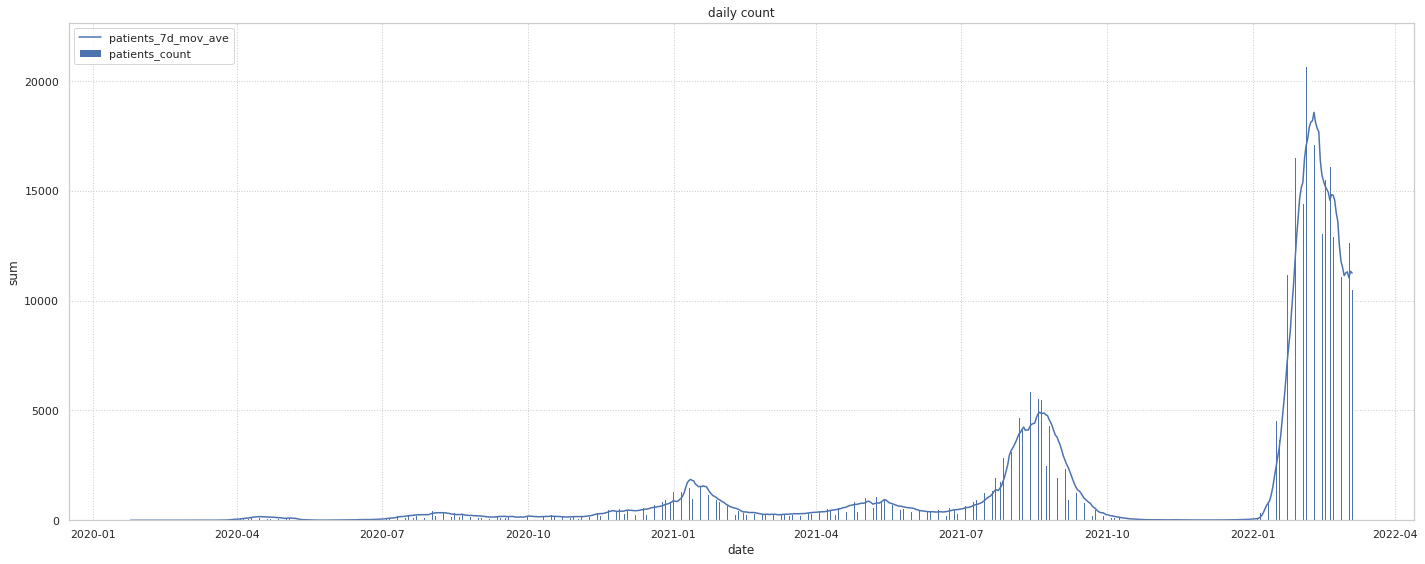

In [15]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

### 日毎の数
ax.set_title('daily count')
ax.set_xlabel('date')
ax.set_ylabel('sum')
ax.bar(x, y1_1, label='patients_count')
ax.plot(x, y1_2, label='patients_7d_mov_ave')
#ax[0].plot(x, y1_3, label='patients_7d_mov_center_ave')
# ax[0].bar(x, y1_4, label='patients_week_mean')
ax.grid(linestyle=':')
ax.legend()

# ### 週毎の合計
# ax[1].set_title('weekly count')
# ax[1].set_xlabel('date')
# ax[1].set_ylabel('sum')
# ax[1].plot(x, y2_1, label='patients_7d_mov_sum')
# ax[1].bar(x, y2_2, label='patients_week_sum')
# ax[1].grid(linestyle=':')
# ax[1].legend()

plt.tight_layout()

---

In [16]:
def get_date(d: datetime) -> datetime:
  """時間が入った `datetime` を `%Y-%m-%d 00:00:00` の `datetime` に変換します"""
  return datetime.datetime.strptime(d.strftime('%Y-%m-%d'), '%Y-%m-%d')

In [17]:
em_start = datetime.datetime(2020, 4, 7)
em_end = datetime.datetime(2020, 5, 25)
def em_term() -> list:
  """緊急事態宣言期間の日付のリスト"""
  em_term = []
  for i in range((em_end - em_start).days + 1):
    em_term.append(em_start + datetime.timedelta(i))
  return em_term

In [18]:
def emergency(d: datetime) -> int:
  """緊急事態宣言期間中か"""
  return int(get_date(d) in em_term())

In [19]:
def em_passed(d: datetime) -> int:
  """緊急事態宣言から経過日数"""
  d = get_date(d)
  return (d - em_start).days if em_start < d else 0

In [20]:
ds_df = pd.DataFrame({
    'timestamp': [d.timestamp() for d in df3.index], # タイムスタンプ
    'year': np.array(df3.index.strftime('%Y'), dtype=np.int64), # 年
    'month': np.array(df3.index.strftime('%m'), dtype=np.int64), # 月
    'day': np.array(df3.index.strftime('%d'), dtype=np.int64), # 日
    'week_day': df3['week_day'], # 曜日
})
# 曜日をダミー変数化
ds_df = pd.concat([ds_df, pd.get_dummies(ds_df['week_day'])], axis=1)
ds_df = ds_df.drop(columns=['week_day'])

# 経過日数
# ds_df['passed'] = [(d - df3['datetime'][0]).days for d in df3['datetime']]
ds_df['passed'] = [(d - df3.index[0]).days for d in df3.index]
# 緊急事態宣言期間中
ds_df['emergency'] = [emergency(d) for d in df3.index]
# 緊急事態宣言経過日数
ds_df['em_passed'] = [em_passed(d) for d in df3.index]
for key in keys:
  k = key.split('_')[0]
  # 日毎の数
  ds_df[f'{k}_count'] = df3[f'{k}_count']
  # 7日間移動平均
  ds_df[f'{k}_7d_mov_ave'] = df3[f'{k}_7d_mov_ave']
  #ds_df[f'{k}_7d_mov_center_ave'] = df3[f'{k}_7d_mov_center_ave']
  # 7日間移動合計
  ds_df[f'{k}_7d_mov_sum'] = df3[f'{k}_7d_mov_sum']

# 日毎の数
# ds_df['patients_count'] = df3['patients_count']
# 7日間移動平均
# ds_df['patients_7d_mov_ave'] = df3['patients_7d_mov_ave']
#ds_df['7d_mov_center_ave'] = df3['patients_7d_mov_center_ave']
# 7日間移動合計
# ds_df['patients_7d_mov_sum'] = df3['patients_7d_mov_sum']

ds_df = ds_df.reset_index(drop=True)
ds_df.tail(15)

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
756,1.645171e+09,2022,2,18,1,0,0,0,0,0,...,682,1129,1417.285714,9921.0,0,0.0,0.0,16129,14574.571429,102022.0
757,1.645258e+09,2022,2,19,0,0,1,0,0,0,...,683,1293,1347.000000,9429.0,0,0.0,0.0,13516,14824.714286,103773.0
758,1.645344e+09,2022,2,20,0,0,0,1,0,0,...,684,1061,1300.714286,9105.0,0,0.0,0.0,12935,14804.857143,103634.0
759,1.645430e+09,2022,2,21,0,1,0,0,0,0,...,685,1321,1238.000000,8666.0,0,0.0,0.0,8805,14586.428571,102105.0
760,1.645517e+09,2022,2,22,0,0,0,0,0,1,...,686,1056,1195.142857,8366.0,0,0.0,0.0,11443,14003.285714,98023.0
761,1.645603e+09,2022,2,23,0,0,0,0,0,0,...,687,1109,1167.857143,8175.0,0,0.0,0.0,14567,13608.428571,95259.0
762,1.645690e+09,2022,2,24,0,0,0,0,1,0,...,688,1024,1141.857143,7993.0,0,0.0,0.0,10169,12509.142857,87564.0
763,1.645776e+09,2022,2,25,1,0,0,0,0,0,...,689,946,1115.714286,7810.0,0,0.0,0.0,11125,11794.285714,82560.0
764,1.645862e+09,2022,2,26,0,0,1,0,0,0,...,690,1070,1083.857143,7587.0,0,0.0,0.0,11562,11515.142857,80606.0
765,1.645949e+09,2022,2,27,0,0,0,1,0,0,...,691,939,1066.428571,7465.0,0,0.0,0.0,10321,11141.714286,77992.0


In [21]:
ds_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 771 entries, 0 to 770
Data columns (total 23 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   timestamp            771 non-null    float64
 1   year                 771 non-null    int64  
 2   month                771 non-null    int64  
 3   day                  771 non-null    int64  
 4   Fri                  771 non-null    uint8  
 5   Mon                  771 non-null    uint8  
 6   Sat                  771 non-null    uint8  
 7   Sun                  771 non-null    uint8  
 8   Thu                  771 non-null    uint8  
 9   Tue                  771 non-null    uint8  
 10  Wed                  771 non-null    uint8  
 11  passed               771 non-null    int64  
 12  emergency            771 non-null    int64  
 13  em_passed            771 non-null    int64  
 14  contacts_count       771 non-null    int64  
 15  contacts_7d_mov_ave  771 non-null    flo

In [22]:
ds_df.describe()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
count,7.710000e+02,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,...,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000,771.000000
mean,1.613117e+09,2020.636835,6.280156,15.747082,0.143969,0.142672,0.142672,0.142672,0.142672,0.142672,...,314.599222,688.937743,686.561577,4805.926070,477.975357,477.975357,3345.827497,1350.586252,1306.091773,9142.621271
std,1.924239e+07,0.628660,3.516101,8.855527,0.351286,0.349965,0.349965,0.349965,0.349965,0.349965,...,217.180597,564.402441,552.108499,3864.765651,784.129249,720.200000,5041.399998,3393.576544,3265.901110,22861.316234
min,1.579853e+09,2020.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.596485e+09,2020.000000,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,118.500000,326.000000,326.000000,2282.000000,0.000000,0.000000,0.000000,54.500000,53.500000,374.500000
50%,1.613117e+09,2021.000000,6.000000,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,311.000000,511.000000,514.428571,3601.000000,0.000000,0.000000,0.000000,260.000000,269.285714,1885.000000
75%,1.629749e+09,2021.000000,9.000000,23.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,503.500000,874.500000,891.428571,6240.000000,959.500000,1037.857143,7265.000000,709.000000,706.928571,4948.500000
max,1.646381e+09,2022.000000,12.000000,31.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,696.000000,3277.000000,2723.000000,19061.000000,4060.000000,2574.142857,18019.000000,21576.000000,18575.000000,130025.000000


In [23]:
ds_df.corr()

,timestamp,year,month,day,Fri,Mon,Sat,Sun,Thu,Tue,...,em_passed,contacts_count,contacts_7d_mov_ave,contacts_7d_mov_sum,querents_count,querents_7d_mov_ave,querents_7d_mov_sum,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
timestamp,1.000000e+00,0.887725,0.175477,-0.000546,-3.793372e-17,-0.000916,-0.004582,-0.002749,0.004582,0.000916,...,0.998600,-0.019114,-0.010207,-0.010205,-0.618827,-0.664807,-0.664807,0.468074,0.468201,0.468202
year,8.877254e-01,1.000000,-0.295856,-0.039615,1.830584e-03,-0.000306,-0.000306,-0.000306,-0.000306,-0.000306,...,0.893529,0.110584,0.119321,0.119322,-0.618291,-0.673174,-0.673174,0.594193,0.589789,0.589790
month,1.754774e-01,-0.295856,1.000000,0.001194,-4.308065e-03,-0.001918,-0.009306,-0.006139,0.010747,0.003359,...,0.160020,-0.279064,-0.278103,-0.278101,0.039246,0.062213,0.062213,-0.301939,-0.292107,-0.292105
day,-5.458888e-04,-0.039615,0.001194,1.000000,5.040604e-03,0.007887,0.004535,0.012497,-0.006361,-0.009294,...,0.000013,0.023024,0.007497,0.007495,0.005929,-0.004558,-0.004558,-0.006648,-0.009064,-0.009065
Fri,-3.793372e-17,0.001831,-0.004308,0.005041,1.000000e+00,-0.167296,-0.167296,-0.167296,-0.167296,-0.167296,...,0.000502,-0.020103,-0.002188,-0.002188,0.023794,-0.002103,-0.002103,0.021894,0.004281,0.004281
Mon,-9.164362e-04,-0.000306,-0.001918,0.007887,-1.672958e-01,1.000000,-0.166415,-0.166415,-0.166415,-0.166415,...,-0.000938,0.038338,0.000019,0.000019,0.102426,0.000352,0.000352,-0.053188,-0.001893,-0.001893
Sat,-4.582181e-03,-0.000306,-0.009306,0.004535,-1.672958e-01,-0.166415,1.000000,-0.166415,-0.166415,-0.166415,...,-0.004322,0.043138,-0.001856,-0.001855,-0.117535,0.000352,0.000352,0.006011,-0.005131,-0.005132
Sun,-2.749309e-03,-0.000306,-0.006139,0.012497,-1.672958e-01,-0.166415,-0.166415,1.000000,-0.166415,-0.166415,...,-0.002630,-0.023027,-0.000954,-0.000953,-0.108264,0.000352,0.000352,-0.015652,-0.003456,-0.003456
Thu,4.582181e-03,-0.000306,0.010747,-0.006361,-1.672958e-01,-0.166415,-0.166415,-0.166415,1.000000,-0.166415,...,0.004171,-0.010140,0.002418,0.002419,0.030112,0.000352,0.000352,0.029084,0.004073,0.004074
Tue,9.164362e-04,-0.000306,0.003359,-0.009294,-1.672958e-01,-0.166415,-0.166415,-0.166415,-0.166415,1.000000,...,0.000753,-0.016406,0.000882,0.000883,0.041058,0.000352,0.000352,-0.009606,0.000025,0.000025


---

In [24]:
ds_df.columns

Index(['timestamp', 'year', 'month', 'day', 'Fri', 'Mon', 'Sat', 'Sun', 'Thu',
       'Tue', 'Wed', 'passed', 'emergency', 'em_passed', 'contacts_count',
       'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 'querents_count',
       'querents_7d_mov_ave', 'querents_7d_mov_sum', 'patients_count',
       'patients_7d_mov_ave', 'patients_7d_mov_sum'],
      dtype='object')

In [25]:
_df = ds_df.copy()
_df = _df.drop(['year', 'month', 'day', 
          'contacts_7d_mov_ave', 'contacts_7d_mov_sum', 
          'querents_7d_mov_ave', 'querents_7d_mov_sum', 
          ], axis=1)
_df

,timestamp,Fri,Mon,Sat,Sun,Thu,Tue,Wed,passed,emergency,em_passed,contacts_count,querents_count,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,1,0,0,0,0,0,0,0,0,0,0,0,1,1.000000,1.0
1,1.579939e+09,0,0,1,0,0,0,0,1,0,0,0,0,1,1.000000,2.0
2,1.580026e+09,0,0,0,1,0,0,0,2,0,0,0,0,0,0.666667,2.0
3,1.580112e+09,0,1,0,0,0,0,0,3,0,0,0,0,0,0.500000,2.0
4,1.580198e+09,0,0,0,0,0,1,0,4,0,0,0,0,0,0.400000,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
766,1.646035e+09,0,1,0,0,0,0,0,766,0,692,1013,0,9632,11259.857143,78819.0
767,1.646122e+09,0,0,0,0,0,1,0,767,0,693,899,0,11813,11312.714286,79189.0
768,1.646208e+09,0,0,0,0,0,0,1,768,0,694,834,0,12693,11045.000000,77315.0
769,1.646294e+09,0,0,0,0,1,0,0,769,0,695,766,0,12251,11342.428571,79397.0


In [26]:
_df2 = _df[['timestamp', 'passed', 'emergency', 'patients_count', 'patients_7d_mov_ave', 'patients_7d_mov_sum']]
_df2

,timestamp,passed,emergency,patients_count,patients_7d_mov_ave,patients_7d_mov_sum
0,1.579853e+09,0,0,1,1.000000,1.0
1,1.579939e+09,1,0,1,1.000000,2.0
2,1.580026e+09,2,0,0,0.666667,2.0
3,1.580112e+09,3,0,0,0.500000,2.0
4,1.580198e+09,4,0,0,0.400000,2.0
...,...,...,...,...,...,...
766,1.646035e+09,766,0,9632,11259.857143,78819.0
767,1.646122e+09,767,0,11813,11312.714286,79189.0
768,1.646208e+09,768,0,12693,11045.000000,77315.0
769,1.646294e+09,769,0,12251,11342.428571,79397.0


In [27]:
sns.set(style="ticks", color_codes=True)
#sns.pairplot(data=_df)

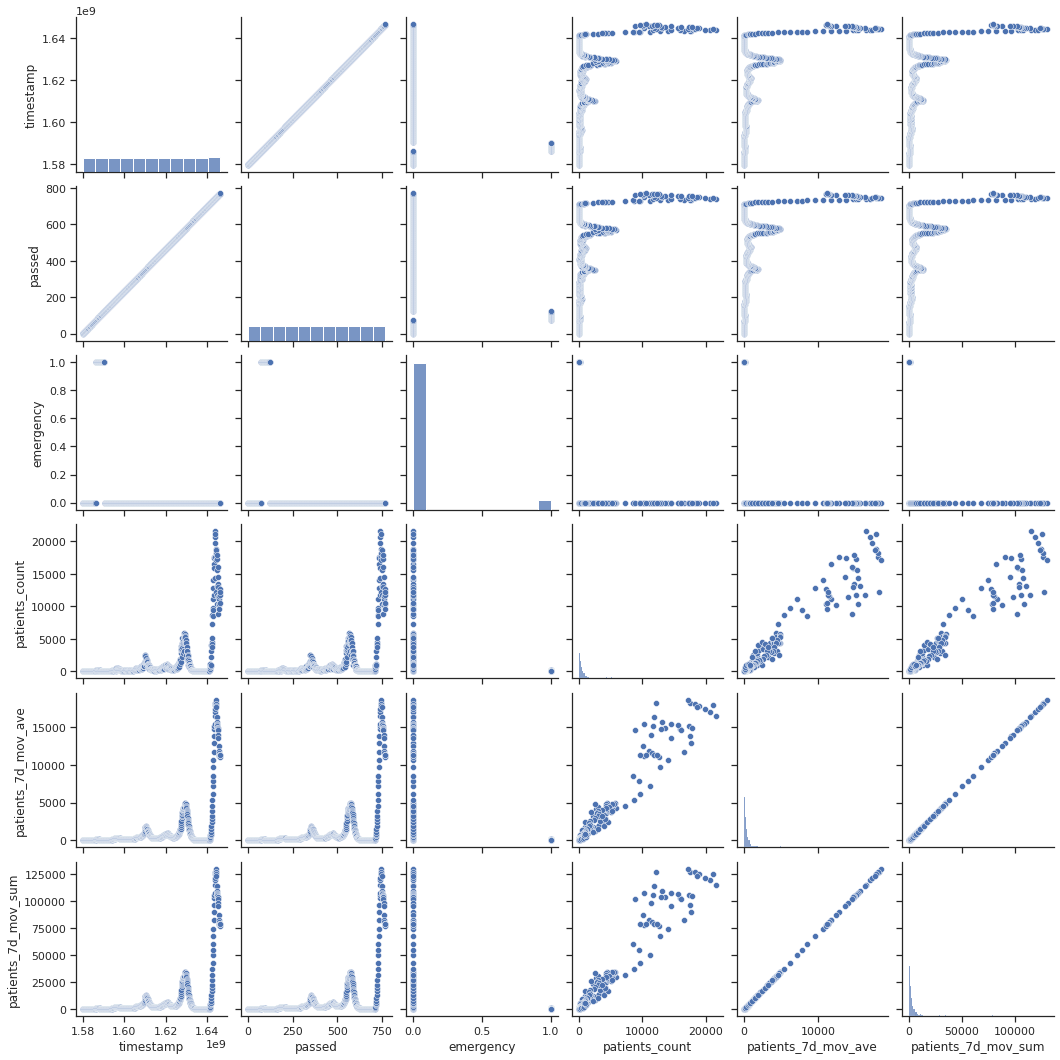

In [28]:
sns.pairplot(data=_df2)

In [29]:
!python -V

Python 3.7.12


In [30]:
!pip freeze

absl-py==1.0.0
alabaster==0.7.12
albumentations==0.1.12
altair==4.2.0
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
arviz==0.11.4
astor==0.8.1
astropy==4.3.1
astunparse==1.6.3
atari-py==0.2.9
atomicwrites==1.4.0
attrs==21.4.0
audioread==2.1.9
autograd==1.3
Babel==2.9.1
backcall==0.2.0
beautifulsoup4==4.6.3
bleach==4.1.0
blis==0.4.1
bokeh==2.3.3
Bottleneck==1.3.4
branca==0.4.2
bs4==0.0.1
CacheControl==0.12.10
cached-property==1.5.2
cachetools==4.2.4
catalogue==1.0.0
certifi==2021.10.8
cffi==1.15.0
cftime==1.5.2
chardet==3.0.4
charset-normalizer==2.0.12
click==7.1.2
cloudpickle==1.3.0
cmake==3.12.0
cmdstanpy==0.9.5
colorcet==3.0.0
colorlover==0.3.0
community==1.0.0b1
contextlib2==0.5.5
convertdate==2.4.0
coverage==3.7.1
coveralls==0.5
crcmod==1.7
cufflinks==0.17.3
cvxopt==1.2.7
cvxpy==1.0.31
cycler==0.11.0
cymem==2.0.6
Cython==0.29.28
daft==0.0.4
dask==2.12.0
datascience==0.10.6
debugpy==1.0.0
decorator==4.4.2
defusedxml==0.7.1
descartes==1.1.0
dill==0.3.4
distributed==